# Bayesian Optimization<a class="anchor" id="chapter1"></a>


## Building the model<a class="anchor" id="section_1_1"></a>

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
np.random.seed(1976)
tf.random.set_seed(1976)

2022-07-05 10:11:50.813744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 10:11:50.813771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def f(x):
    return 1/2*( tf.sin(20*x)/(1+x)+3*pow(x,3)*tf.cos(5*x)+10*pow((x-0.5),2)-0.6)
    #return(6*x-2)*(6*x-2)*tf.sin(12*x-4)

In [3]:
from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer(query_points):
    return {
        OBJECTIVE: Dataset(query_points, f(query_points))
    }

2022-07-05 10:12:15.705494: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-05 10:12:15.705541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (macaron): /proc/driver/nvidia/version does not exist


In [4]:
#X=np.array([[0],[0.1],[0.3],[0.4],[0.5],[0.6],[0.8],[0.9],[1]])
X=np.array([[0],[0.25],[0.5],[0.75],[1]])
num_initial_points=len(X)
initial_data = observer(X)

In [5]:
xx = np.linspace(0, 1, 100).reshape(100, 1)
plt.plot(xx,f(xx), label='f')
plt.scatter(initial_data[OBJECTIVE].query_points,initial_data[OBJECTIVE].observations)

In [6]:

k=gpflow.kernels.RBF(1,0.1)           ## the squared exponential kernel 



In [11]:
mean=tf.math.reduce_mean(initial_data[OBJECTIVE].observations[:])
mean_function=gpflow.mean_functions.Constant(mean)
#mean_function = gpflow.mean_functions.Linear(1.0, 0.0)

model=gpflow.models.GPR((initial_data[OBJECTIVE].query_points[:], initial_data[OBJECTIVE].observations[:]),k,noise_variance=1e-05)
opt =  tf.optimizers.Adam()
opt.minimize(model.training_loss, model.trainable_variables)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [12]:
model

<gpflow.models.gpr.GPR object at 0x7f38ea4aeb60>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.821311  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0439003 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1e-05     │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [13]:
## the training loss is simply the neg log likelihood
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss,variables=model.trainable_variables,options=dict(disp=True, maxiter=1000),)
print(f"log posterior density at optimum: {model.log_posterior_density()}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60380D+00    |proj g|=  8.24416D-04

At iterate    1    f=  6.60380D+00    |proj g|=  8.13104D-05

At iterate    2    f=  6.60380D+00    |proj g|=  1.49944D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.499D-06   6.604D+00
  F =   6.6037979473600990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
log posterior density at optimum: -6.603797947360099


 This problem is unconstrained.


In [14]:
n=num_initial_points
## GP model_matrix inversed

sigma_epsilon=float(model.likelihood.variance.numpy())

data_X=initial_data[OBJECTIVE].query_points[:]
data_Y=initial_data[OBJECTIVE].observations[:] 
K_bf_inv=np.linalg.inv(k(data_X)+sigma_epsilon*np.eye(n))
#K_bf_inv=np.linalg.inv(k(data_X))
## correlation vector

def K(x):
    
    if isinstance(x, np.float64):
        K=k(x,data_X).reshape((1,n))
    else:
        K=k(x,data_X[:])
    return K.numpy().T
##  correlation coefficient
def k_coef(x):
    if len(x)==1:
        return k(x,x).numpy()
    else :
        return k(x,x).numpy().diagonal().reshape((len(x),1))
    

def predict(x):
    #mean=float(model.mean_function.c.numpy())+np.dot(K(x).T,np.dot(K_bf_inv,data_Y))
    mean=np.dot(K(x).T,np.dot(K_bf_inv,data_Y))
    if len(x)==1:
        var=k_coef(x)+sigma_epsilon-np.dot(K(x).T,np.dot(K_bf_inv,K(x))).reshape(len(x),1)
    else:
        var=k_coef(x)+sigma_epsilon-np.dot(K(x).T,np.dot(K_bf_inv,K(x))).diagonal().reshape(len(x),1)    
    return mean,var 

In [15]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)
mean_c,var_c=predict(xx)

## generate 100 samples from posterior
#samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data[OBJECTIVE].query_points[:], initial_data[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean, 'C0', label='predict_f', lw=2)
plt.plot(xx, f(xx) ,'C1',label='f', lw=2)
plt.fill_between(xx[:,0],
                mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                color='C0', alpha=0.2)
plt.fill_between(xx[:,0],
                mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                color='C2', alpha=0.2)
plt.plot(xx, mean_c, 'C2', label='predict' ,lw=2)
plt.legend()
#plt.plot(xx, samples[:, :, 0].T, 'C1', linewidth=.5)
#plt.xlim(-0.1, 1.1);


## Expected Improvement  

In [16]:
x_best=initial_data[OBJECTIVE].query_points[int(tf.math.argmin(initial_data[OBJECTIVE].observations[:]))].reshape((1,1))

In [17]:
from scipy.stats import norm
def u(x): ## il faut utiliser le type numpy x=np.array([[0.5]])
    mean,var=predict(x)
    mean_,_=predict(x_best)
    return (mean_-mean)/np.sqrt(var)
def EI(x):
    _,sigma_square=predict(x)
    return (np.sqrt(sigma_square)*[u(x)*norm.cdf(u(x))+norm.pdf(u(x))]).reshape(x.shape)

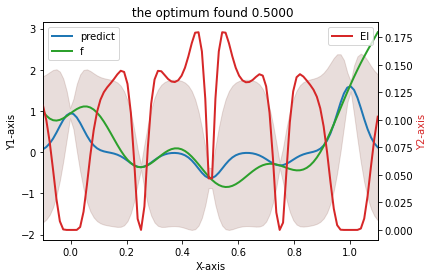

In [18]:
## iteration 0
mean, var = predict(xx)
## plot 
fig, ax1 = plt.subplots()
  
color = 'tab:red'
ax1.set_xlabel('X-axis')  
ax1.set_ylabel('Y1-axis')  
ax1.plot(xx, mean, 'C0',label='predict', lw=2)
ax1.plot(xx, f(xx), 'C2',label="f", lw=2)
ax1.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C5', alpha=0.2)
ax1.tick_params(axis ='y')  
plt.legend()
plt.title(' the optimum found %.4f' %x_best)
ax2 = ax1.twinx()  
ax2.set_ylabel('Y2-axis', color = color) 
ax2.plot(xx,EI(xx),'C3',label='EI',lw=2) 
ax2.tick_params(axis ='y')
plt.legend()
plt.xlim(-0.1, 1.1);


## Bayesian Optimization 

In [19]:
def neg_log_EI(x):
    return -np.log(EI(x))

In [20]:
from scipy.optimize import basinhopping
from scipy.optimize import minimize
x_0 =x_best

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01403D+00    |proj g|=  5.76967D-01

At iterate    1    f=  6.85391D+00    |proj g|=  6.26205D-01

At iterate    2    f=  6.71168D+00    |proj g|=  7.25788D-01

At iterate    3    f=  6.62627D+00    |proj g|=  3.91619D-01

At iterate    4    f=  6.61193D+00    |proj g|=  7.21738D-02

At iterate    5    f=  6.61102D+00    |proj g|=  3.93713D-02

At iterate    6    f=  6.61037D+00    |proj g|=  8.91578D-03

At iterate    7    f=  6.61034D+00    |proj g|=  1.59176D-03

At iterate    8    f=  6.61034D+00    |proj g|=  1.64195D-04

At iterate    9    f=  6.61034D+00    |proj g|=  7.61489D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
/tmp/ipykernel_3808166/1517924239.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.log(EI(x))
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63757D+00    |proj g|=  1.88905D+00

At iterate    1    f=  6.07433D+00    |proj g|=  5.77145D-01

At iterate    2    f=  6.04664D+00    |proj g|=  2.99967D-01

At iterate    3    f=  6.03973D+00    |proj g|=  8.92174D-02

At iterate    4    f=  6.03908D+00    |proj g|=  8.99767D-03

At iterate    5    f=  6.03907D+00    |proj g|=  7.11448D-03

At iterate    6    f=  6.03906D+00    |proj g|=  7.55822D-04

At iterate    7    f=  6.03906D+00    |proj g|=  2.82107D-04

At iterate    8    f=  6.03906D+00    |proj g|=  1.03337D-03

At iterate    9    f=  6.03906D+00    |proj g|=  2.09654D-03

At iterate   10    f=  6.03905D+00    |proj g|=  4.13758D-03

At iterate   11    f=  6.03905D+00    |proj g|=  7.19851D-03

At iterate   12    f=  6.03905D+00    |proj g|=  1.21058D-02

At iterate   13    f=  6.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93421D+00    |proj g|=  2.34032D+00

At iterate    1    f=  5.67482D+00    |proj g|=  3.26119D+00

At iterate    2    f=  5.50827D+00    |proj g|=  3.62797D-01

At iterate    3    f=  5.49744D+00    |proj g|=  6.43206D-02

At iterate    4    f=  5.49697D+00    |proj g|=  5.69658D-02

At iterate    5    f=  5.49575D+00    |proj g|=  2.06315D-02

At iterate    6    f=  5.49574D+00    |proj g|=  2.92159D-03

At iterate    7    f=  5.49573D+00    |proj g|=  8.29846D-03

At iterate    8    f=  5.49573D+00    |proj g|=  1.55354D-02

At iterate    9    f=  5.49572D+00    |proj g|=  2.96796D-02

At iterate   10    f=  5.49569D+00    |proj g|=  5.04338D-02

At iterate   11    f=  5.49561D+00    |proj g|=  8.25743D-02

At iterate   12    f=  5.49544D+00    |proj g|=  1.25270D-01

At iterate   13    f=  5.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90424D+00    |proj g|=  2.84176D+00

At iterate    1    f=  1.28498D+00    |proj g|=  1.48840D+00

At iterate    2    f=  1.26396D+00    |proj g|=  4.49044D-01

At iterate    3    f=  1.24252D+00    |proj g|=  4.47282D-01

At iterate    4    f=  1.13812D+00    |proj g|=  1.61982D+00

At iterate    5    f=  1.00987D+00    |proj g|=  2.21739D+00

At iterate    6    f=  8.45002D-01    |proj g|=  1.54927D+00

At iterate    7    f=  5.82894D-01    |proj g|=  9.45765D-01

At iterate    8    f=  3.61780D-01    |proj g|=  1.42745D+00

At iterate    9    f=  2.46484D-01    |proj g|=  1.66848D+00

At iterate   10    f=  1.64660D-01    |proj g|=  8.34428D-01

At iterate   11    f=  1.44216D-01    |proj g|=  1.18964D-01

At iterate   12    f=  1.41034D-01    |proj g|=  2.02884D-01

At iterate   13    f=  1.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09557D+00    |proj g|=  3.48691D+00

At iterate    1    f= -2.18341D+00    |proj g|=  3.32633D+00

At iterate    2    f= -2.62727D+00    |proj g|=  4.98936D+00

At iterate    3    f= -3.05299D+00    |proj g|=  8.77782D-01

At iterate    4    f= -3.12872D+00    |proj g|=  8.72797D-01

At iterate    5    f= -3.22499D+00    |proj g|=  8.58074D-01

At iterate    6    f= -3.57749D+00    |proj g|=  1.61681D+00

At iterate    7    f= -4.17926D+00    |proj g|=  2.38374D+00

At iterate    8    f= -4.89448D+00    |proj g|=  1.28837D+00

At iterate    9    f= -5.11104D+00    |proj g|=  3.25161D-01

At iterate   10    f= -5.15670D+00    |proj g|=  1.16837D-01

At iterate   11    f= -5.17455D+00    |proj g|=  1.70095D-01

At iterate   12    f= -5.18696D+00    |proj g|=  1.09423D-01

At iterate   13    f= -5.1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50788D+00    |proj g|=  4.23249D+00

At iterate    1    f= -6.98878D+00    |proj g|=  5.24191D+00

At iterate    2    f= -7.63104D+00    |proj g|=  2.21960D+00

At iterate    3    f= -7.93880D+00    |proj g|=  1.30679D+00

At iterate    4    f= -8.23700D+00    |proj g|=  1.26985D+00

At iterate    5    f= -9.62746D+00    |proj g|=  2.52921D+00

At iterate    6    f= -1.05341D+01    |proj g|=  1.69559D+00

At iterate    7    f= -1.08915D+01    |proj g|=  1.38946D+00

At iterate    8    f= -1.09627D+01    |proj g|=  9.26280D-01

At iterate    9    f= -1.09924D+01    |proj g|=  3.66187D-01

At iterate   10    f= -1.10217D+01    |proj g|=  1.49596D-01

At iterate   11    f= -1.10343D+01    |proj g|=  9.95078D-02

At iterate   12    f= -1.10423D+01    |proj g|=  2.12303D-02

At iterate   13    f= -1.1

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10101D+01    |proj g|=  4.64911D+00

At iterate    1    f= -1.22486D+01    |proj g|=  4.52760D+00

At iterate    2    f= -1.26631D+01    |proj g|=  2.11518D+00

At iterate    3    f= -1.29300D+01    |proj g|=  1.71763D+00

At iterate    4    f= -1.33054D+01    |proj g|=  1.67123D+00

At iterate    5    f= -1.44998D+01    |proj g|=  2.16329D+00

At iterate    6    f= -1.59474D+01    |proj g|=  2.44643D+00

At iterate    7    f= -1.65984D+01    |proj g|=  9.90830D-01

At iterate    8    f= -1.67907D+01    |proj g|=  2.97041D-01

At iterate    9    f= -1.68456D+01    |proj g|=  2.43898D-01

At iterate   10    f= -1.68861D+01    |proj g|=  2.59178D-01

At iterate   11    f= -1.69094D+01    |proj g|=  7.83868D-02

At iterate   12    f= -1.69168D+01    |proj g|=  4.59564D-02

At iterate   13    f= -1.6

 This problem is unconstrained.
/tmp/ipykernel_3808166/3193403779.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55455D+01    |proj g|=  5.01015D+00

At iterate    1    f= -1.74708D+01    |proj g|=  3.88191D+00

At iterate    2    f= -1.77983D+01    |proj g|=  2.12463D+00

At iterate    3    f= -1.80307D+01    |proj g|=  2.20969D+00

At iterate    4    f= -1.86381D+01    |proj g|=  2.03703D+00

At iterate    5    f= -2.01098D+01    |proj g|=  3.88216D+00

At iterate    6    f= -2.21194D+01    |proj g|=  2.05066D+00

At iterate    7    f= -2.25614D+01    |proj g|=  1.37880D+00

At iterate    8    f= -2.27092D+01    |proj g|=  2.52684D-01

At iterate    9    f= -2.27458D+01    |proj g|=  3.06537D-01

At iterate   10    f= -2.27924D+01    |proj g|=  1.20487D-01

At iterate   11    f= -2.28060D+01    |proj g|=  1.06634D-01

At iterate   12    f= -2.28151D+01    |proj g|=  3.05751D-02

At iterate   13    f= -2.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46951D+01    |proj g|=  5.60448D+00

At iterate    1    f= -2.78514D+01    |proj g|=  2.96912D+00

At iterate    2    f= -2.82484D+01    |proj g|=  2.90350D+00

At iterate    3    f= -2.86898D+01    |proj g|=  4.57859D+00

At iterate    4    f= -3.15672D+01    |proj g|=  6.73543D+00

At iterate    5    f= -3.35845D+01    |proj g|=  1.72181D+00

At iterate    6    f= -3.39379D+01    |proj g|=  7.50029D-01

At iterate    7    f= -3.41664D+01    |proj g|=  8.43416D-01

At iterate    8    f= -3.43777D+01    |proj g|=  8.32386D-01

At iterate    9    f= -3.45953D+01    |proj g|=  9.61850D-01

At iterate   10    f= -3.46282D+01    |proj g|=  4.56158D-01

At iterate   11    f= -3.46337D+01    |proj g|=  6.00525D-02

At iterate   12    f= -3.46372D+01    |proj g|=  3.35974D-01

At iterate   13    f= -3.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.93021D+01    |proj g|=  5.85222D+00

At iterate    1    f= -3.30244D+01    |proj g|=  3.37607D+00

At iterate    2    f= -3.35874D+01    |proj g|=  4.35219D+00

At iterate    3    f= -3.43706D+01    |proj g|=  6.02921D+00

At iterate    4    f= -3.73525D+01    |proj g|=  3.82438D+00

At iterate    5    f= -3.90076D+01    |proj g|=  2.90551D+00

At iterate    6    f= -4.00598D+01    |proj g|=  7.05192D-01

At iterate    7    f= -4.02448D+01    |proj g|=  6.62428D-01

At iterate    8    f= -4.03683D+01    |proj g|=  5.48695D-01

At iterate    9    f= -4.05359D+01    |proj g|=  2.45107D-01

At iterate   10    f= -4.05445D+01    |proj g|=  1.05208D-01

At iterate   11    f= -4.05690D+01    |proj g|=  2.52759D-01

At iterate   12    f= -4.05770D+01    |proj g|=  2.04410D-01

At iterate   13    f= -4.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39261D+01    |proj g|=  6.07670D+00

At iterate    1    f= -3.81898D+01    |proj g|=  3.78026D+00

At iterate    2    f= -3.90707D+01    |proj g|=  6.88052D+00

At iterate    3    f= -4.03730D+01    |proj g|=  6.92145D+00

At iterate    4    f= -4.50022D+01    |proj g|=  3.10703D+00

At iterate    5    f= -4.56782D+01    |proj g|=  1.17277D+00

At iterate    6    f= -4.60036D+01    |proj g|=  7.14838D-01

At iterate    7    f= -4.61278D+01    |proj g|=  7.57985D-01

At iterate    8    f= -4.63844D+01    |proj g|=  7.06627D-01

At iterate    9    f= -4.64816D+01    |proj g|=  3.81925D-01

At iterate   10    f= -4.64907D+01    |proj g|=  1.72030D-01

At iterate   11    f= -4.64967D+01    |proj g|=  2.82304D-02

At iterate   12    f= -4.65071D+01    |proj g|=  2.71702D-01

At iterate   13    f= -4.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.85683D+01    |proj g|=  6.27255D+00

At iterate    1    f= -4.33566D+01    |proj g|=  4.18158D+00

At iterate    2    f= -4.45929D+01    |proj g|=  5.26172D+00

At iterate    3    f= -4.72433D+01    |proj g|=  8.89954D+00

At iterate    4    f= -4.97148D+01    |proj g|=  5.69177D+00

At iterate    5    f= -5.11678D+01    |proj g|=  3.73783D+00

At iterate    6    f= -5.20577D+01    |proj g|=  4.81409D-01

At iterate    7    f= -5.21566D+01    |proj g|=  6.89119D-01

At iterate    8    f= -5.23584D+01    |proj g|=  2.68718D-01

At iterate    9    f= -5.24243D+01    |proj g|=  5.60464D-02

At iterate   10    f= -5.24378D+01    |proj g|=  1.85183D-01

At iterate   11    f= -5.24476D+01    |proj g|=  1.03050D-01

At iterate   12    f= -5.24571D+01    |proj g|=  4.43230D-02

At iterate   13    f= -5.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.78912D+01    |proj g|=  6.61752D+00

At iterate    1    f= -5.36857D+01    |proj g|=  4.97776D+00

At iterate    2    f= -5.78720D+01    |proj g|=  1.56120D+01

At iterate    3    f= -5.99700D+01    |proj g|=  6.27750D+00

At iterate    4    f= -6.16819D+01    |proj g|=  4.12296D+00

At iterate    5    f= -6.33246D+01    |proj g|=  5.60575D+00

At iterate    6    f= -6.37558D+01    |proj g|=  2.47722D+00

At iterate    7    f= -6.40773D+01    |proj g|=  2.77997D-01

At iterate    8    f= -6.41987D+01    |proj g|=  4.07518D-01

At iterate    9    f= -6.42825D+01    |proj g|=  3.38154D-01

At iterate   10    f= -6.43226D+01    |proj g|=  4.98990D-01

At iterate   11    f= -6.43385D+01    |proj g|=  4.63194D-01

At iterate   12    f= -6.43481D+01    |proj g|=  4.85238D-02

At iterate   13    f= -6.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.72601D+01    |proj g|=  6.90447D+00

At iterate    1    f= -6.40212D+01    |proj g|=  5.76625D+00

At iterate    2    f= -7.09534D+01    |proj g|=  3.38809D+00

At iterate    3    f= -7.19390D+01    |proj g|=  6.87494D+00

At iterate    4    f= -7.44901D+01    |proj g|=  4.05662D+00

At iterate    5    f= -7.51249D+01    |proj g|=  2.72565D+00

At iterate    6    f= -7.56871D+01    |proj g|=  6.05817D-01

At iterate    7    f= -7.58905D+01    |proj g|=  6.38538D-01

At iterate    8    f= -7.60894D+01    |proj g|=  4.22274D-01

At iterate    9    f= -7.61964D+01    |proj g|=  2.95366D-01

At iterate   10    f= -7.62129D+01    |proj g|=  9.46465D-02

At iterate   11    f= -7.62262D+01    |proj g|=  2.57363D-01

At iterate   12    f= -7.62432D+01    |proj g|=  2.89520D-01

At iterate   13    f= -7.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.19591D+01    |proj g|=  7.03036D+00

At iterate    1    f= -6.91925D+01    |proj g|=  6.15808D+00

At iterate    2    f= -7.71917D+01    |proj g|=  3.25244D+00

At iterate    3    f= -7.78398D+01    |proj g|=  6.59598D+00

At iterate    4    f= -7.98138D+01    |proj g|=  3.33817D+00

At iterate    5    f= -8.11897D+01    |proj g|=  1.50691D+00

At iterate    6    f= -8.17754D+01    |proj g|=  5.61224D-01

At iterate    7    f= -8.20470D+01    |proj g|=  4.36522D-01

At iterate    8    f= -8.21395D+01    |proj g|=  6.46425D-01

At iterate    9    f= -8.21622D+01    |proj g|=  2.11130D-01

At iterate   10    f= -8.21820D+01    |proj g|=  3.38100D-01

At iterate   11    f= -8.21952D+01    |proj g|=  5.40294D-01

At iterate   12    f= -8.22089D+01    |proj g|=  4.38975D-01

At iterate   13    f= -8.2

 This problem is unconstrained.


<Figure size 432x288 with 0 Axes>

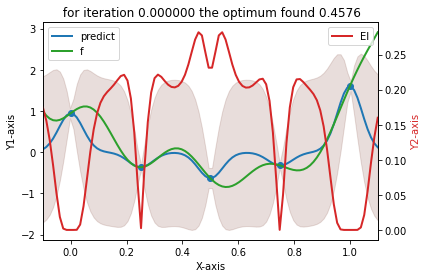

<Figure size 432x288 with 0 Axes>

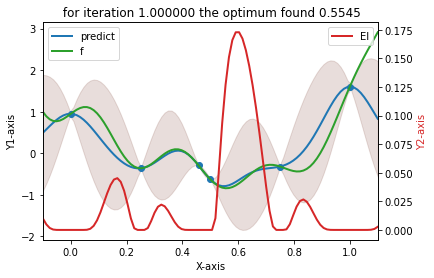

<Figure size 432x288 with 0 Axes>

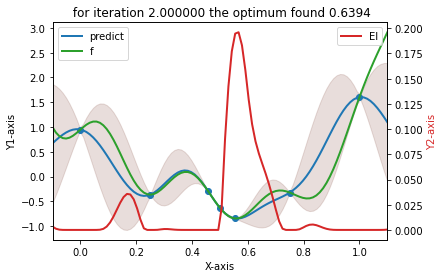

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

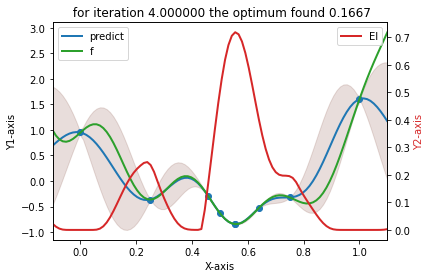

<Figure size 432x288 with 0 Axes>

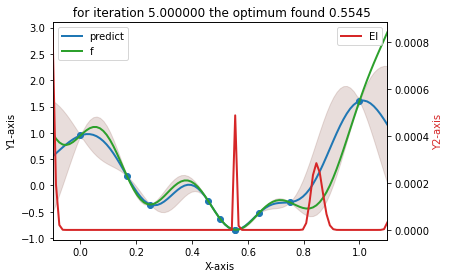

<Figure size 432x288 with 0 Axes>

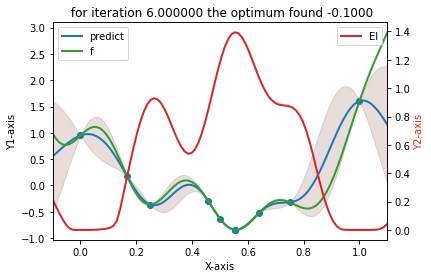

<Figure size 432x288 with 0 Axes>

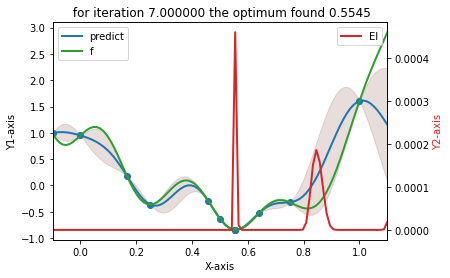

<Figure size 432x288 with 0 Axes>

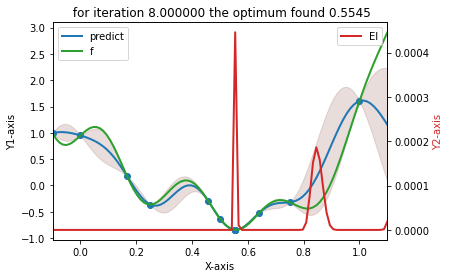

<Figure size 432x288 with 0 Axes>

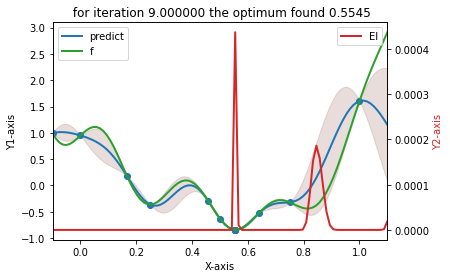

<Figure size 432x288 with 0 Axes>

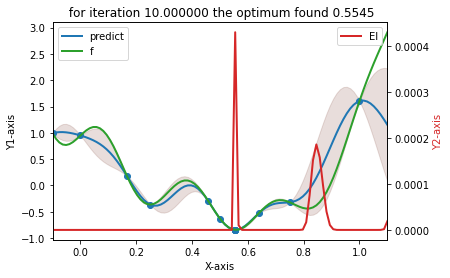

<Figure size 432x288 with 0 Axes>

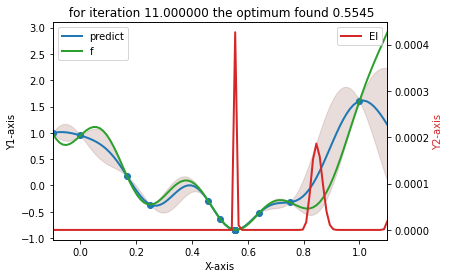

<Figure size 432x288 with 0 Axes>

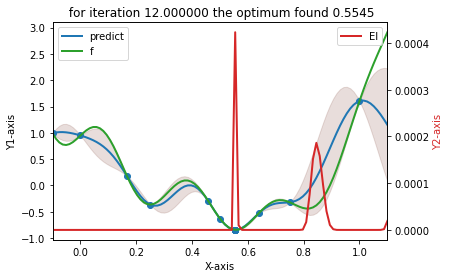

<Figure size 432x288 with 0 Axes>

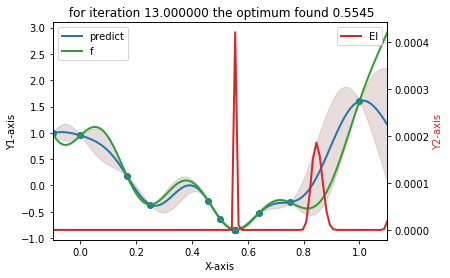

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

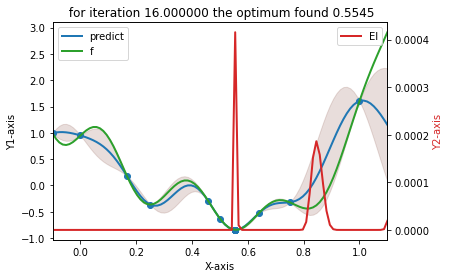

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

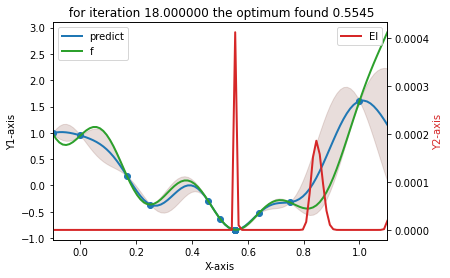

<Figure size 432x288 with 0 Axes>

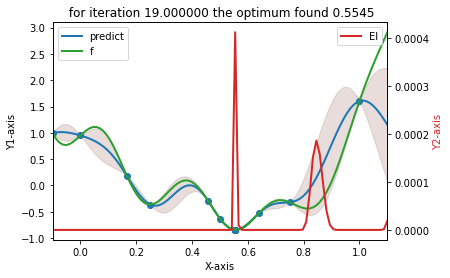

In [21]:
num_iter=20

## initilization 
data_X=initial_data[OBJECTIVE].query_points[:]
data_Y=initial_data[OBJECTIVE].observations[:] 
## Building the first model .... already done \
for i in range(num_iter):
     
    ## finding the minimum of the merit function 
    #min=minimize(neg_EI, x_0, args=(),bounds=[(0,1)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})
    #min=minimize(neg_EI, x_0, args=(),bounds=[(0,1)],method='Nelder-Mead',options = {'disp':True,'maxiter':1000})
    #x_best=min.x.reshape(1,1)
    #x_0=float(min.x)+0.1 ### reinitialiser l'optimiseur a partir de l'optimum trouve 
    ## updating the data with the new observation point 
    x_best=xx[np.argmin(neg_log_EI(xx))].reshape(1,1)
    
     ## plots 
    plt.figure()
    fig, ax1 = plt.subplots()
    mean, var = predict(xx)
    color = 'tab:red'
    ax1.set_xlabel('X-axis')  
    ax1.set_ylabel('Y1-axis')  
    ax1.plot(xx, mean, 'C0',label='predict', lw=2)
    ax1.plot(xx, f(xx), 'C2',label="f", lw=2)
    ax1.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C5', alpha=0.2)
    plt.scatter(data_X,data_Y)
    ax1.tick_params(axis ='y')  
    plt.legend()
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Y2-axis', color = color) 
    ax2.plot(xx,EI(xx),'C3',label='EI',lw=2) 
    ax2.tick_params(axis ='y')
    plt.title(' for iteration %f the optimum found %.4f' %(i,x_best))
    plt.legend()
    plt.xlim(-0.1, 1.1);

    X=np.concatenate([X,x_best])
    data_X=np.concatenate([data_X,x_best])
    data_Y=np.concatenate([data_Y,f(x_best)])
    
    
    ##updating the number of observation points 
    n=n+1
     

    ## Building the model  over the new training data 
    mean=tf.math.reduce_mean(data_Y)
    mean_function=gpflow.mean_functions.Constant(mean)
    model=gpflow.models.GPR((data_X, data_Y),k,mean_function,noise_variance=1e-5)
    
    ## finding the new hyperparameters
    opt.minimize(model.training_loss, model.trainable_variables)
    optimizer.minimize(model.training_loss,variables=model.trainable_variables,options=dict(disp=True, maxiter=1000),)
    sigma_epsilon=float(model.likelihood.variance.numpy())
    ## computing the inverse of the new correlation matrix
    K_bf_inv=np.linalg.inv(k(data_X)+sigma_epsilon*np.eye(n))
    



In [32]:
data_X

array([[ 0.        ],
       [ 0.25      ],
       [ 0.5       ],
       [ 0.75      ],
       [ 1.        ],
       [ 0.45757576],
       [ 0.55454545],
       [ 0.63939394],
       [ 0.55454545],
       [ 0.16666667],
       [ 0.55454545],
       [-0.1       ],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545],
       [ 0.55454545]])